A 검사 (신규 자격 검사)
1. A1 : 움직이는 물체에 대한 속도예측 능력
    - (A1-1): cond1 = 1: left, 2: right
    - (A1-2): cond2 = 1: slow, 2: normal, 3: fast
    - (A1-3): response = 0: N, 1: Y
    - (A1-4): responetime

2. A2 : 자동차의 이동속도와 가속도를 고려한 정지거리 예측능력
    - (A2-1): cond1 = 1: slow, 2: normal, 3: fast
    - (A2-2): cond2 = 1: slow, 2: normal, 3: fast
    - (A2-3): response = 0: N, 1: Y
    - (A2-4): responsetime

3. A3 : 운전 시 주의를 자유롭게 조율할 수 있는 능력
    - (A3-1): cond1 = 1: small, 2: big
    - (A3-2): cond2 = 1-8 clockwise
    - (A3-3): cond3 = 1: left, 2: right
    - (A3-4): cond4 = 1-8 clockwise
    - (A3-5): response1 = 1: valid correct, 2: valid incorrect, 3: invalid correct, 4: invalid incorrect
    - (A3-6): response2 = 0: N, 1: Y
    - (A3-7): responsetime

4. A4 : 필요한 자극에만 집중하여 빠르고 정확하게 반응하는 능력
    - (A4-1): cond1 = 1: con, 2: incon
    - (A4-2): cond2 = 1: red, 2: green
    - (A4-3): response1 = 1: correct, 2: incorrect
    - (A4-4): response2 = 0: N, 1: Y
    - (A4-5): responsetime

5. A5 : 변화사항을 기억하여 탐지하는 능력
    - (A5-1): cond = 1: non change, 2: pos change, 3: color change, 4: shape change
    - (A5-2): response1 = 1: correct answer, 2: incorrect answer
    - (A5-3): response2 = 0: N, 1: Y

6. A6 : 판단능력, 돌방상황에서 교통정보 파악 능력
    - (A6-1): count

7. A7 : 판단능력, 돌발상황에서 교통정보 파악 능력
    - (A7-1): count

8. A8 : 질문지형 검사
    - (A8-1): count - 타당성 척도 1(응답 왜곡 정도)
    - (A8-2): count - 타당성 척도 2(반응 일관성 정도)

9. A9 : 질문지형 검사
    - (A9-1): count - 정서안정성
    - (A9-2): count - 행동안정성
    - (A9-3): count - 현실판단력
    - (A9-4): count - 정신적민첩석
    - (A9-5): count - 생활스트레스


B 검사 (자격 유지 검사)
1. B1, B2 : 시야각 측정 검사
    - (B1-1, B2-1): 1: correct answer, 2: incorrect answer
    - (B1-2, B2-2): 응답시간
    -  (B1-3, B-3): 1: change-correct answer, 2: change-incorrect answer, 3: non change_correct answer, 4: non change_incorrect answer

2. B3 : 시각 운동 협응 속도
    - (B3-1): 1: correct answer, 2: incorrect answer
    - (B3-2): 반응시간

3. B4 : 선택적 주의력 측정 검사
    - (B4-1): 1: correct answer, 2: incorrect answer in congruent trials / 3 and 5 correct answer, 4 and 6 incorrect answer in incongruent trials
    - (B4-2): 반응시간

4. B5 : 공간 판단력
    - (B5-1): 1 correct answer, 2: incorrect answer
    - (B5-2): 반응시간

5. B6, B7 : 시각적 기억력
    - (B6, B7): 1: correct answer, 2: incorrect answer

6. B8 : 주의 지속능력 측정 검사
    - (B8): 1: correct answer, 2: incorrect answer

7. B9, B10 : 다중과제 수행 능력
    - (B9-1, B10-1): aud, hit
    - (B9-2, B10-2): aud, miss
    - (B9-3, B10-3): aud, fa
    - (B9-4, B10-4): aud, cr
    - (B9-5, B10-5): vis, err
    - (B10-6): vis2, right response


8. Age와 다른 피처간의 결합 실험

In [1]:
# 라이브러리 import
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
import optuna
from tqdm import tqdm
from typing import Tuple, List, Sequence
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
tqdm.pandas()

In [2]:
# 점수 계산 함수
def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece
    
def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")
        
    submission_df = submission_df[submission_df.iloc[:, 0].isin(answer_df.iloc[:, 0])]
    submission_df.index = range(submission_df.shape[0])
    
    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns[1:]:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)


    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)


    brier_scores = []
    ece_scores = []
    
    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns[1:]:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values
        
        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)
        
        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)
    
    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)
    
    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece
    
    return combined_score

In [3]:
# 각 시퀀스 통계
def convert_age(val): # 나이 변환 
    if pd.isna(val): return np.nan
    try:
        base = int(str(val)[:-1])
        return base if str(val)[-1] == "a" else base + 5
    except:
        return np.nan

def split_testdate(val): # 날짜 변환
    try:
        v = int(val)
        return v // 100, v % 100
    except:
        return np.nan, np.nan

def seq_mean(series): # 각 시퀀스 평균
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").mean() if x else np.nan
    )

def seq_std(series): # 각 시퀀스 표준편차
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").std() if x else np.nan
    )

def seq_rate(series, target="1"): # 각 시퀀스에서 target이 차지하는 비율
    return series.fillna("").progress_apply(
        lambda x: str(x).split(",").count(target) / len(x.split(",")) if x else np.nan
    )

def masked_mean_from_csv_series(cond_series, val_series, mask_val): # 평균 반응 시간
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)

    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)

    mask = (cond_arr == mask_val)
    with np.errstate(invalid="ignore"):
        sums = np.nansum(np.where(mask, val_arr, np.nan), axis=1)
        counts = np.sum(mask, axis=1)
        out = sums / np.where(counts==0, np.nan, counts)
    return pd.Series(out, index=cond_series.index)

def masked_mean_in_set_series(cond_series, val_series, mask_set): # 특정 집합의 평균
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)

    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)

    mask = np.isin(cond_arr, list(mask_set))
    with np.errstate(invalid="ignore"):
        sums = np.nansum(np.where(mask, val_arr, np.nan), axis=1)
        counts = np.sum(mask, axis=1)
        out = sums / np.where(counts == 0, np.nan, counts)
    return pd.Series(out, index=cond_series.index)

# ---- 추가 ----
def seq_median(series): # 각 시퀀스 중앙값
    return series.fillna("").progress_apply(
        lambda x: np.median(np.fromstring(x, sep=",")) if x else np.nan
    )

def seq_min(series): # 각 시퀀스 최솟값
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").min() if x else np.nan
    )

def seq_max(series): # 각 시퀀스 최댓값
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").max() if x else np.nan
    )

def safe_skew(arr):
    # 데이터가 2개 미만이거나, 표준편차가 0에 매우 가까우면 계산하지 않음
    if len(arr) < 2 or np.std(arr) < 1e-9:
        return 0.0  # (또는 np.nan)
    return skew(arr)

def seq_skew(series): # 각 시퀀스 왜도
    return series.fillna("").progress_apply(
        lambda x: safe_skew(np.fromstring(x, sep=",")) if x else np.nan
    )

def safe_kurt(arr):
    if len(arr) < 2 or np.std(arr) < 1e-9:
        return 0.0
    return kurtosis(arr)

def seq_kurt(series): # 각 시퀀스 첨도
    return series.fillna("").progress_apply(
        lambda x: safe_kurt(np.fromstring(x, sep=",")) if x else np.nan
    )

def seq_quantile(series, q=0.75): # 각 시퀀스 특정 분위수 (기본값: 75%)
    return series.fillna("").progress_apply(
        lambda x: np.quantile(np.fromstring(x, sep=","), q) if x else np.nan
    )

def masked_std_from_csv_series(cond_series, val_series, mask_val): # 표준편차 반응 시간
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)
    mask = (cond_arr == mask_val)
    masked_vals = np.where(mask, val_arr, np.nan)
    counts = np.sum(~np.isnan(masked_vals), axis=1)
    out = np.full(masked_vals.shape[0], np.nan)
    valid_rows_mask = (counts >= 2)
    
    if np.any(valid_rows_mask):
        std_results = np.nanstd(masked_vals[valid_rows_mask], axis=1, ddof=1)
        out[valid_rows_mask] = std_results
        
    return pd.Series(out, index=cond_series.index)

In [ ]:
def preprocess_A(train_A):
    df = train_A.copy()
    
    # ---- Age, TestDate 파생 ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- A1 ----
    print("Step 2: A1 feature 생성...")
    feats["A1_resp_rate"] = seq_rate(df["A1-3"], "1")
    feats["A1_rt_mean"]   = seq_mean(df["A1-4"])
    feats["A1_rt_std"]    = seq_std(df["A1-4"])
    feats["A1_rt_left"]   = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 1)
    feats["A1_rt_right"]  = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 2)
    feats["A1_rt_side_diff"] = feats["A1_rt_left"] - feats["A1_rt_right"]
    feats["A1_rt_slow"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 1)
    feats["A1_rt_fast"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 3)
    feats["A1_rt_speed_diff"] = feats["A1_rt_slow"] - feats["A1_rt_fast"]

    # ---- A2 ----
    print("Step 3: A2 feature 생성...")
    feats["A2_resp_rate"] = seq_rate(df["A2-3"], "1")
    feats["A2_rt_mean"]   = seq_mean(df["A2-4"])
    feats["A2_rt_std"]    = seq_std(df["A2-4"])
    feats["A2_rt_cond1_diff"] = masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 3)
    feats["A2_rt_cond2_diff"] = masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 3)

    # ---- A3 ----
    print("Step 4: A3 feature 생성...")
    s = df["A3-5"].fillna("")
    total   = s.apply(lambda x: len(x.split(",")) if x else 0)
    valid   = s.apply(lambda x: sum(v in {"1","2"} for v in x.split(",")) if x else 0)
    invalid = s.apply(lambda x: sum(v in {"3","4"} for v in x.split(",")) if x else 0)
    correct = s.apply(lambda x: sum(v in {"1","3"} for v in x.split(",")) if x else 0)
    feats["A3_valid_ratio"]   = (valid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_invalid_ratio"] = (invalid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_correct_ratio"] = (correct / total).replace([np.inf,-np.inf], np.nan)

    feats["A3_resp2_rate"] = seq_rate(df["A3-6"], "1")
    feats["A3_rt_mean"]    = seq_mean(df["A3-7"])
    feats["A3_rt_std"]     = seq_std(df["A3-7"])
    feats["A3_rt_size_diff"] = masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 2)
    feats["A3_rt_side_diff"] = masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 2)

    # ---- A4 ----
    print("Step 5: A4 feature 생성...")
    feats["A4_acc_rate"]   = seq_rate(df["A4-3"], "1")
    feats["A4_resp2_rate"] = seq_rate(df["A4-4"], "1")
    feats["A4_rt_mean"]    = seq_mean(df["A4-5"])
    feats["A4_rt_std"]     = seq_std(df["A4-5"])
    feats["A4_stroop_diff"] = masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 2) - \
                              masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 1)
    feats["A4_rt_color_diff"] = masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 1) - \
                                masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 2)

    # ---- A5 ----
    print("Step 6: A5 feature 생성...")
    feats["A5_acc_rate"]   = seq_rate(df["A5-2"], "1")
    feats["A5_resp2_rate"] = seq_rate(df["A5-3"], "1")
    feats["A5_acc_nonchange"] = masked_mean_from_csv_series(df["A5-1"], df["A5-2"], 1)
    feats["A5_acc_change"]    = masked_mean_in_set_series(df["A5-1"], df["A5-2"], {2,3,4})

    # ---- Drop ----
    print("Step 7: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "A1-1","A1-2","A1-3","A1-4",
        "A2-1","A2-2","A2-3","A2-4",
        "A3-1","A3-2","A3-3","A3-4","A3-5","A3-6","A3-7",
        "A4-1","A4-2","A4-3","A4-4","A4-5",
        "A5-1","A5-2","A5-3"
    ]
    print("A 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)

In [23]:
def preprocess_A(train_A):
    df = train_A.copy()
    
    # ---- Age, TestDate 파생 ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- A1 ----
    print("Step 2: A1 feature 생성...")
    feats["A1_resp_rate"] = seq_rate(df["A1-3"], "1")
    feats["A1_rt_mean"]   = seq_mean(df["A1-4"])
    feats["A1_rt_std"]    = seq_std(df["A1-4"])
    feats["A1_rt_left"]   = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 1)
    feats["A1_rt_right"]  = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 2)
    feats["A1_rt_side_diff"] = feats["A1_rt_left"] - feats["A1_rt_right"]
    feats["A1_rt_slow"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 1)
    feats["A1_rt_fast"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 3)
    feats["A1_rt_speed_diff"] = feats["A1_rt_slow"] - feats["A1_rt_fast"]

    # ---- A2 ----
    print("Step 3: A2 feature 생성...")
    feats["A2_resp_rate"] = seq_rate(df["A2-3"], "1")
    feats["A2_rt_mean"]   = seq_mean(df["A2-4"])
    feats["A2_rt_std"]    = seq_std(df["A2-4"])
    feats["A2_rt_cond1_diff"] = masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 3)
    feats["A2_rt_cond2_diff"] = masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 3)

    # ---- A3 ----
    print("Step 4: A3 feature 생성...")
    s = df["A3-5"].fillna("")
    total   = s.apply(lambda x: len(x.split(",")) if x else 0)
    valid   = s.apply(lambda x: sum(v in {"1","2"} for v in x.split(",")) if x else 0)
    invalid = s.apply(lambda x: sum(v in {"3","4"} for v in x.split(",")) if x else 0)
    correct = s.apply(lambda x: sum(v in {"1","3"} for v in x.split(",")) if x else 0)
    feats["A3_valid_ratio"]   = (valid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_invalid_ratio"] = (invalid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_correct_ratio"] = (correct / total).replace([np.inf,-np.inf], np.nan)

    feats["A3_resp2_rate"] = seq_rate(df["A3-6"], "1")
    feats["A3_rt_mean"]    = seq_mean(df["A3-7"])
    feats["A3_rt_std"]     = seq_std(df["A3-7"])
    feats["A3_rt_size_diff"] = masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 2)
    feats["A3_rt_side_diff"] = masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 2)

    # ---- A4 ----
    print("Step 5: A4 feature 생성...")
    feats["A4_acc_rate"]   = seq_rate(df["A4-3"], "1")
    feats["A4_resp2_rate"] = seq_rate(df["A4-4"], "1")
    feats["A4_rt_mean"]    = seq_mean(df["A4-5"])
    feats["A4_rt_std"]     = seq_std(df["A4-5"])
    feats["A4_stroop_diff"] = masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 2) - \
                              masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 1)
    feats["A4_rt_color_diff"] = masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 1) - \
                                masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 2)

    # ---- A5 ----
    print("Step 6: A5 feature 생성...")
    feats["A5_acc_rate"]   = seq_rate(df["A5-2"], "1")
    feats["A5_resp2_rate"] = seq_rate(df["A5-3"], "1")
    feats["A5_acc_nonchange"] = masked_mean_from_csv_series(df["A5-1"], df["A5-2"], 1)
    feats["A5_acc_change"]    = masked_mean_in_set_series(df["A5-1"], df["A5-2"], {2,3,4})

    # ---- Drop ----
    print("Step 7: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "A1-1","A1-2","A1-3","A1-4",
        "A2-1","A2-2","A2-3","A2-4",
        "A3-1","A3-2","A3-3","A3-4","A3-5","A3-6","A3-7",
        "A4-1","A4-2","A4-3","A4-4","A4-5",
        "A5-1","A5-2","A5-3"
    ]
    print("A 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)

In [6]:
# train_B 전처리
def preprocess_B(train_B):
    df = train_B.copy()

    # ---- Age, TestDate ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- B1 ----
    print("Step 2: B1 feature 생성...")
    feats["B1_acc_task1"] = seq_rate(df["B1-1"], "1")
    feats["B1_rt_mean"]   = seq_mean(df["B1-2"])
    feats["B1_rt_std"]    = seq_std(df["B1-2"])
    feats["B1_acc_task2"] = seq_rate(df["B1-3"], "1")

    # ---- B2 ----
    print("Step 3: B2 feature 생성...")
    feats["B2_acc_task1"] = seq_rate(df["B2-1"], "1")
    feats["B2_rt_mean"]   = seq_mean(df["B2-2"])
    feats["B2_rt_std"]    = seq_std(df["B2-2"])
    feats["B2_acc_task2"] = seq_rate(df["B2-3"], "1")

    # ---- B3 ----
    print("Step 4: B3 feature 생성...")
    feats["B3_acc_rate"] = seq_rate(df["B3-1"], "1")
    feats["B3_rt_mean"]  = seq_mean(df["B3-2"])
    feats["B3_rt_std"]   = seq_std(df["B3-2"])

    # ---- B4 ----
    print("Step 5: B4 feature 생성...")
    feats["B4_acc_rate"] = seq_rate(df["B4-1"], "1")
    feats["B4_rt_mean"]  = seq_mean(df["B4-2"])
    feats["B4_rt_std"]   = seq_std(df["B4-2"])

    # ---- B5 ----
    print("Step 6: B5 feature 생성...")
    feats["B5_acc_rate"] = seq_rate(df["B5-1"], "1")
    feats["B5_rt_mean"]  = seq_mean(df["B5-2"])
    feats["B5_rt_std"]   = seq_std(df["B5-2"])

    # ---- B6~B8 ----
    print("Step 7: B6~B8 feature 생성...")
    feats["B6_acc_rate"] = seq_rate(df["B6"], "1")
    feats["B7_acc_rate"] = seq_rate(df["B7"], "1")
    feats["B8_acc_rate"] = seq_rate(df["B8"], "1")

    # ---- Drop ----
    print("Step 8: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "B1-1","B1-2","B1-3",
        "B2-1","B2-2","B2-3",
        "B3-1","B3-2",
        "B4-1","B4-2",
        "B5-1","B5-2",
        "B6","B7","B8"
    ]

    print("B 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)
    # return pd.concat([df, feats], axis=1)

In [7]:
def _has(df, cols):  # 필요한 컬럼이 모두 있는지
    return all(c in df.columns for c in cols)

def _safe_div(a, b, eps=1e-6):
    return a / (b + eps)

# -------- A 파생 --------
def add_features_A(df: pd.DataFrame) -> pd.DataFrame:
    feats = df.copy()
    eps = 1e-6

    # 0) Month-Month 단일축
    if _has(feats, ["Year","Month"]):
        feats["YearMonthIndex"] = feats["Year"] * 12 + feats["Month"]

    # 1) 속도-정확도 트레이드오프
    if _has(feats, ["A1_rt_mean","A1_resp_rate"]):
        feats["A1_speed_acc_tradeoff"] = _safe_div(feats["A1_rt_mean"], feats["A1_resp_rate"], eps)
    if _has(feats, ["A2_rt_mean","A2_resp_rate"]):
        feats["A2_speed_acc_tradeoff"] = _safe_div(feats["A2_rt_mean"], feats["A2_resp_rate"], eps)
    if _has(feats, ["A4_rt_mean","A4_acc_rate"]):
        feats["A4_speed_acc_tradeoff"] = _safe_div(feats["A4_rt_mean"], feats["A4_acc_rate"], eps)

    # 2) RT 변동계수(CV)
    for k in ["A1","A2","A3","A4"]:
        m, s = f"{k}_rt_mean", f"{k}_rt_std"
        if _has(feats, [m, s]):
            feats[f"{k}_rt_cv"] = _safe_div(feats[s], feats[m], eps)

    # 3) 조건 차이 절댓값(편향 크기)
    for name, base in [
        ("A1_rt_side_gap_abs",  "A1_rt_side_diff"),
        ("A1_rt_speed_gap_abs", "A1_rt_speed_diff"),
        ("A2_rt_cond1_gap_abs", "A2_rt_cond1_diff"),
        ("A2_rt_cond2_gap_abs", "A2_rt_cond2_diff"),
        ("A4_stroop_gap_abs",   "A4_stroop_diff"),
        ("A4_color_gap_abs",    "A4_rt_color_diff"),
    ]:
        if base in feats.columns:
            feats[name] = feats[base].abs()

    # 4) 정확도 패턴 심화
    if _has(feats, ["A5_acc_change","A5_acc_nonchange"]):
        feats["A5_change_nonchange_gap"] = feats["A5_acc_change"] - feats["A5_acc_nonchange"]

    # 5) 간단 메타 리스크 스코어(휴리스틱)
    parts = []
    if "A4_stroop_gap_abs" in feats: parts.append(0.30 * feats["A4_stroop_gap_abs"].fillna(0))
    if "A4_acc_rate" in feats:       parts.append(0.20 * (1 - feats["A4_acc_rate"].fillna(0)))
    if "A3_valid_invalid_gap" in feats:
        parts.append(0.20 * feats["A3_valid_invalid_gap"].fillna(0).abs())
    if "A1_rt_cv" in feats: parts.append(0.20 * feats["A1_rt_cv"].fillna(0))
    if "A2_rt_cv" in feats: parts.append(0.10 * feats["A2_rt_cv"].fillna(0))
    if parts:
        feats["RiskScore"] = sum(parts)

    # NaN/inf 정리
    feats.replace([np.inf, -np.inf], np.nan, inplace=True)
    return feats

# -------- B 파생 --------
def add_features_B(df: pd.DataFrame) -> pd.DataFrame:
    feats = df.copy()
    eps = 1e-6

    # 0) Year-Month 단일축
    if _has(feats, ["Year","Month"]):
        feats["YearMonthIndex"] = feats["Year"] * 12 + feats["Month"]

    # 1) 속도-정확도 트레이드오프 (B1~B5)
    for k, acc_col, rt_col in [
        ("B1", "B1_acc_task1", "B1_rt_mean"),
        ("B2", "B2_acc_task1", "B2_rt_mean"),
        ("B3", "B3_acc_rate",  "B3_rt_mean"),
        ("B4", "B4_acc_rate",  "B4_rt_mean"),
        ("B5", "B5_acc_rate",  "B5_rt_mean"),
    ]:
        if _has(feats, [rt_col, acc_col]):
            feats[f"{k}_speed_acc_tradeoff"] = _safe_div(feats[rt_col], feats[acc_col], eps)

    # 2) RT 변동계수(CV)
    for k in ["B1","B2","B3","B4","B5"]:
        m, s = f"{k}_rt_mean", f"{k}_rt_std"
        if _has(feats, [m, s]):
            feats[f"{k}_rt_cv"] = _safe_div(feats[s], feats[m], eps)

    # 3) 간단 메타 리스크 스코어(휴리스틱)
    parts = []
    for k in ["B4","B5"]:  # 주의집중/스트룹 유사 과제 가중
        if _has(feats, [f"{k}_rt_cv"]):
            parts.append(0.25 * feats[f"{k}_rt_cv"].fillna(0))
    for k in ["B3","B4","B5"]:
        acc = f"{k}_acc_rate" if k != "B1" and k != "B2" else None
        if k in ["B1","B2"]:
            acc = f"{k}_acc_task1"
        if acc in feats:
            parts.append(0.25 * (1 - feats[acc].fillna(0)))
    for k in ["B1","B2"]:
        tcol = f"{k}_speed_acc_tradeoff"
        if tcol in feats:
            parts.append(0.25 * feats[tcol].fillna(0))
    if parts:
        feats["RiskScore_B"] = sum(parts)

    feats.replace([np.inf, -np.inf], np.nan, inplace=True)
    return feats

In [11]:
# Data Load
BASE_DIR = "./data"

train_meta = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
train_A = pd.read_csv(os.path.join(BASE_DIR, "train", "A.csv"))
train_B = pd.read_csv(os.path.join(BASE_DIR, "train", "B.csv"))

# train_A에 Label결합
train_A = train_meta.loc[train_meta['Test'] == 'A', ["Test_id", "Test", 'Label']].merge(train_A, on="Test_id", how="left")
train_A = train_A.drop(columns=['Test_x', 'Test_y'])

# train_B에 Label결합
train_B = train_meta.loc[train_meta['Test'] == 'B', ["Test_id", "Test", 'Label']].merge(train_B, on="Test_id", how="left")
train_B = train_B.drop(columns=['Test_x', 'Test_y'])
print("train_meta:", train_meta.shape)
print("train_A:", train_A.shape)
print("train_B:", train_B.shape)

train_meta: (944767, 3)
train_A: (647241, 37)
train_B: (297526, 31)


In [12]:
# 그래프 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 설정
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

In [13]:
# 순서대로 각 피처 분석 A, B 순서
train_A.columns

Index(['Test_id', 'Label', 'PrimaryKey', 'Age', 'TestDate', 'A1-1', 'A1-2',
       'A1-3', 'A1-4', 'A2-1', 'A2-2', 'A2-3', 'A2-4', 'A3-1', 'A3-2', 'A3-3',
       'A3-4', 'A3-5', 'A3-6', 'A3-7', 'A4-1', 'A4-2', 'A4-3', 'A4-4', 'A4-5',
       'A5-1', 'A5-2', 'A5-3', 'A6-1', 'A7-1', 'A8-1', 'A8-2', 'A9-1', 'A9-2',
       'A9-3', 'A9-4', 'A9-5'],
      dtype='object')

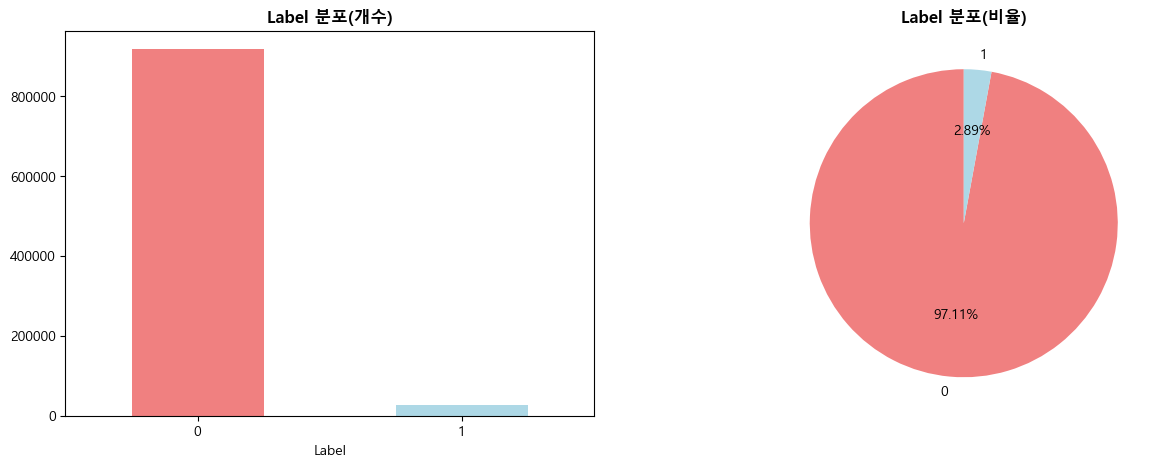

train_A + train_B 전체 Label
Label_0(count): 917485, Label_1(count): 27282
전체 데이터에서의 비율: Label_0: 0.97, Label_1: 0.03
Label_0 : Label_1 = 33.63 : 1
0의 개수가 압도적으로 많음 언더샘플링 or 모델의 weight 조절 필요


In [14]:
# 전체 Label 분포
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_meta['Label'].value_counts().plot(kind='bar', ax = axes[0], color=['lightcoral', 'lightblue'])
axes[0].set_title('Label 분포(개수)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)

sizes = train_meta['Label'].value_counts()
labels = ['0', '1']
colors = ['lightcoral', 'lightblue']
axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
axes[1].set_title('Label 분포(비율)', fontsize=12, fontweight='bold')

plt.show()

# 0의 개수가 압도적으로 많음 언더샘플링 or 모델의 weight 조절 필요
Label_0 = (train_meta['Label'] == 0).sum()
Label_1 = (train_meta['Label'] == 1).sum()
print('train_A + train_B 전체 Label')
print(f'Label_0(count): {Label_0}, Label_1(count): {Label_1}')
print(f'전체 데이터에서의 비율: Label_0: {Label_0/len(train_meta):.2f}, Label_1: {Label_1/len(train_meta):.2f}')
print(f'Label_0 : Label_1 = {Label_0/Label_1:.2f} : 1')
print('0의 개수가 압도적으로 많음 언더샘플링 or 모델의 weight 조절 필요')

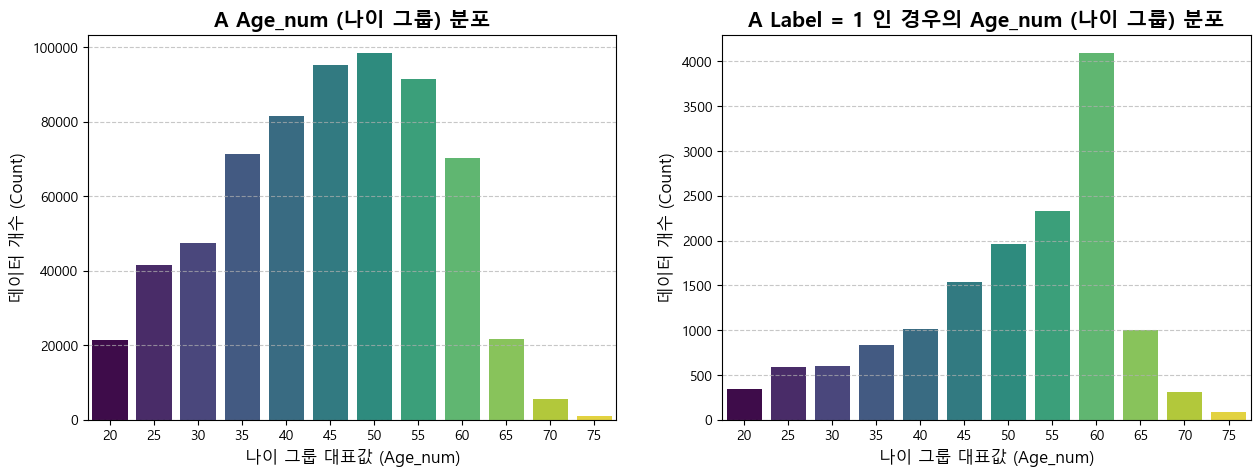

In [15]:
# Age 피처
train_A['Age_num'] = train_A['Age'].map(convert_age).astype('int32')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

age_order = sorted(train_A['Age_num'].dropna().unique())
sns.countplot(data=train_A, x='Age_num', ax=axes[0], palette='viridis', order=age_order, hue='Age_num', legend=False)
axes[0].set_title('A Age_num (나이 그룹) 분포', fontsize=15, fontweight='bold')
axes[0].set_xlabel('나이 그룹 대표값 (Age_num)', fontsize=12)
axes[0].set_ylabel('데이터 개수 (Count)', fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

train_A_label1 = train_A[train_A['Label'] == 1].copy()
age_order_label1 = sorted(train_A_label1['Age_num'].dropna().unique())

sns.countplot( data=train_A_label1, x='Age_num', ax=axes[1], palette='viridis', order=age_order_label1, hue='Age_num', legend=False)
axes[1].set_title('A Label = 1 인 경우의 Age_num (나이 그룹) 분포', fontsize=15, fontweight='bold')
axes[1].set_xlabel('나이 그룹 대표값 (Age_num)', fontsize=12)
axes[1].set_ylabel('데이터 개수 (Count)', fontsize=12)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Age가 커질수록 증가하고 60대 초반이 가장 많은 비중을 차지

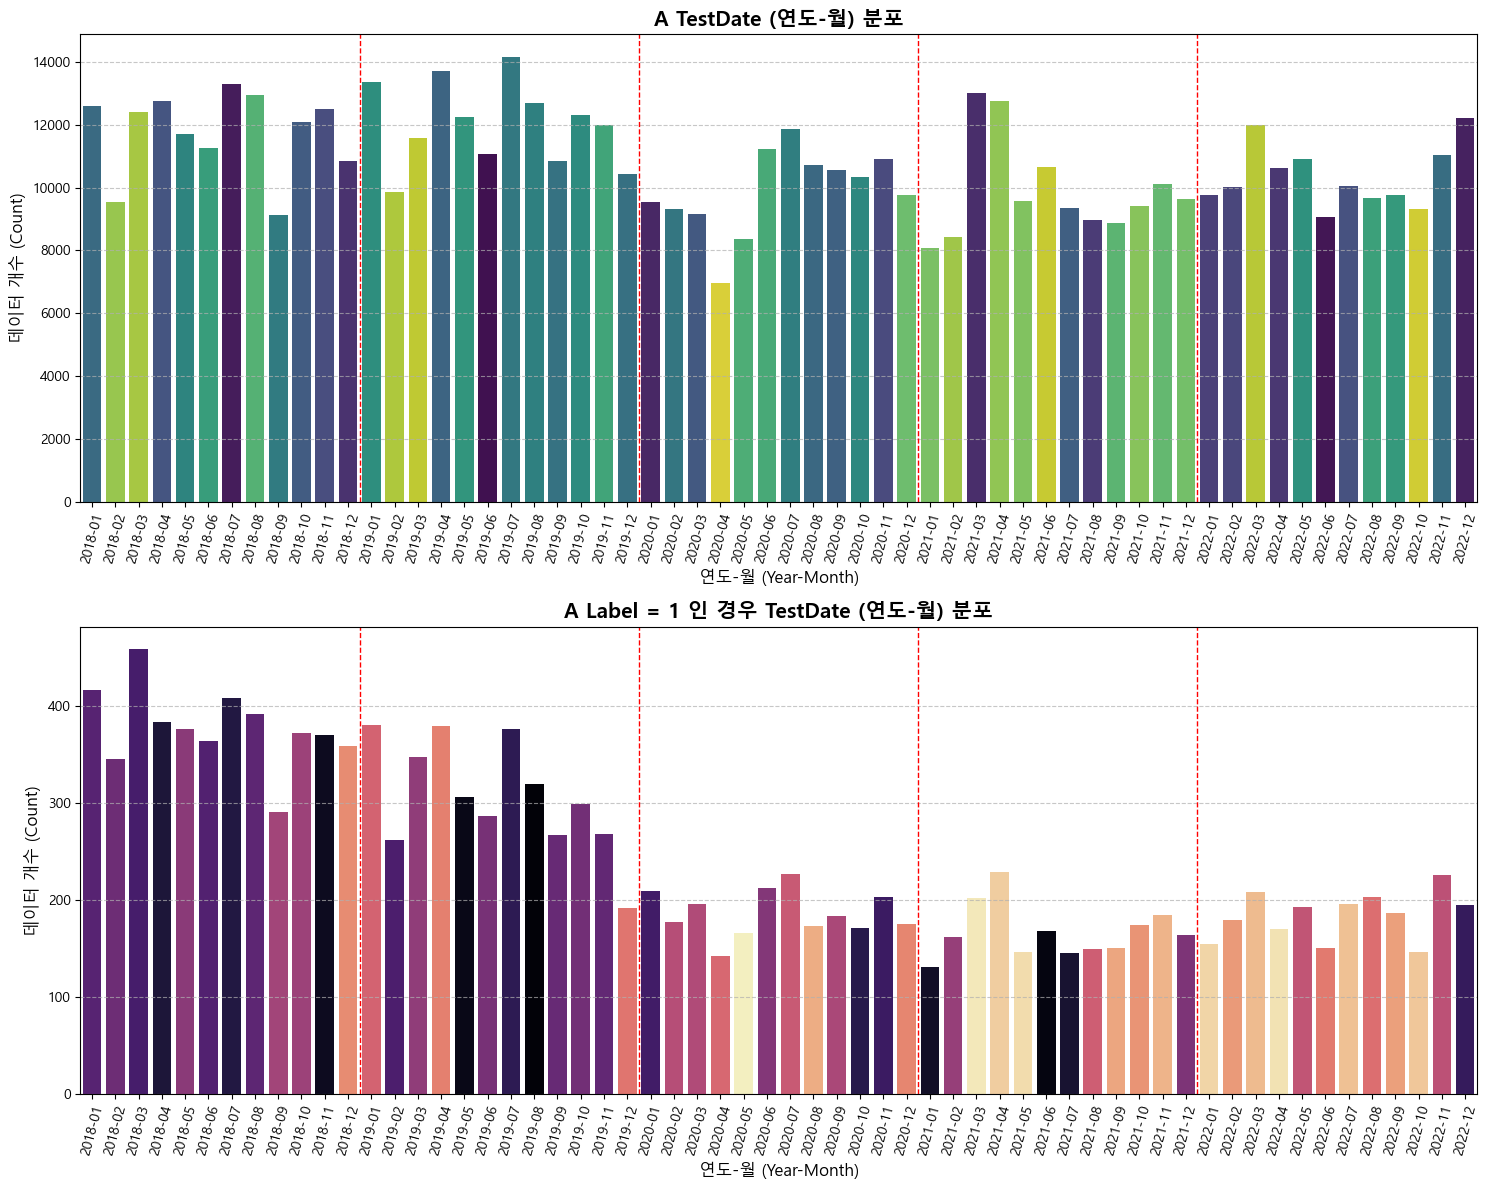

In [16]:
# TestDate 피처
ym = train_A['TestDate'].map(split_testdate)
train_A['Year'] = [y for y, m in ym]
train_A['Year'] = train_A['Year'].astype('Int32')

train_A['Month'] = [m for y, m in ym]
train_A['Month'] = train_A['Month'].astype('Int32')

train_A['YearMonth'] = train_A['Year'].astype(str) + '-' + train_A['Month'].astype(str).str.zfill(2)
train_A['YearMonth'] = train_A['YearMonth'].replace('<NA>-nan', np.nan).replace('nan-<NA>', np.nan)

fig, axes = plt.subplots(2, 1, figsize=(15, 12))
yearmonth_order = sorted(train_A['YearMonth'].dropna().unique())
sns.countplot(
    data=train_A, x='YearMonth', ax=axes[0], palette='viridis',
    order=yearmonth_order, hue='YearMonth', legend=False
)

axes[0].set_title('A TestDate (연도-월) 분포', fontsize=15, fontweight='bold')
axes[0].set_xlabel('연도-월 (Year-Month)', fontsize=12)
axes[0].set_ylabel('데이터 개수 (Count)', fontsize=12)
axes[0].tick_params(axis='x', rotation=75)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

train_A_label1 = train_A[train_A['Label'] == 1].copy()
sns.countplot(
        data=train_A_label1, x='YearMonth', ax=axes[1], palette='magma',
        order=yearmonth_order, hue='YearMonth', legend=False
)
axes[1].set_title('A Label = 1 인 경우 TestDate (연도-월) 분포', fontsize=15, fontweight='bold')
axes[1].set_xlabel('연도-월 (Year-Month)', fontsize=12)
axes[1].set_ylabel('데이터 개수 (Count)', fontsize=12)
axes[1].tick_params(axis='x', rotation=75)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

current_year = None
for i, ym in enumerate(yearmonth_order):
    year = ym.split('-')[0]
    # 첫 번째 연도 이후, 연도가 변경될 때
    if current_year is not None and year != current_year:
        # 각 서브플롯(axes[0], axes[1])에 수직선을 그립니다.
        # 선의 위치는 연도가 바뀌는 인덱스(i)의 왼쪽, 즉 i - 0.5 입니다.
        axes[0].axvline(i - 0.5, color='red', linestyle='--', linewidth=1)
        if not train_A_label1.empty: # Label=1 데이터가 있을 때만 아래 그래프에도 선 추가
            axes[1].axvline(i - 0.5, color='red', linestyle='--', linewidth=1)
    current_year = year
# ------------------------------------

plt.tight_layout()
plt.show()
# 2019년 11월을 기점으로 급격하게 감소함

In [17]:
# 2018 - 2021 5개의 연도
year = sorted(train_A['Year'].unique()) # 각 연도마다 데이터들의 분포를 구함

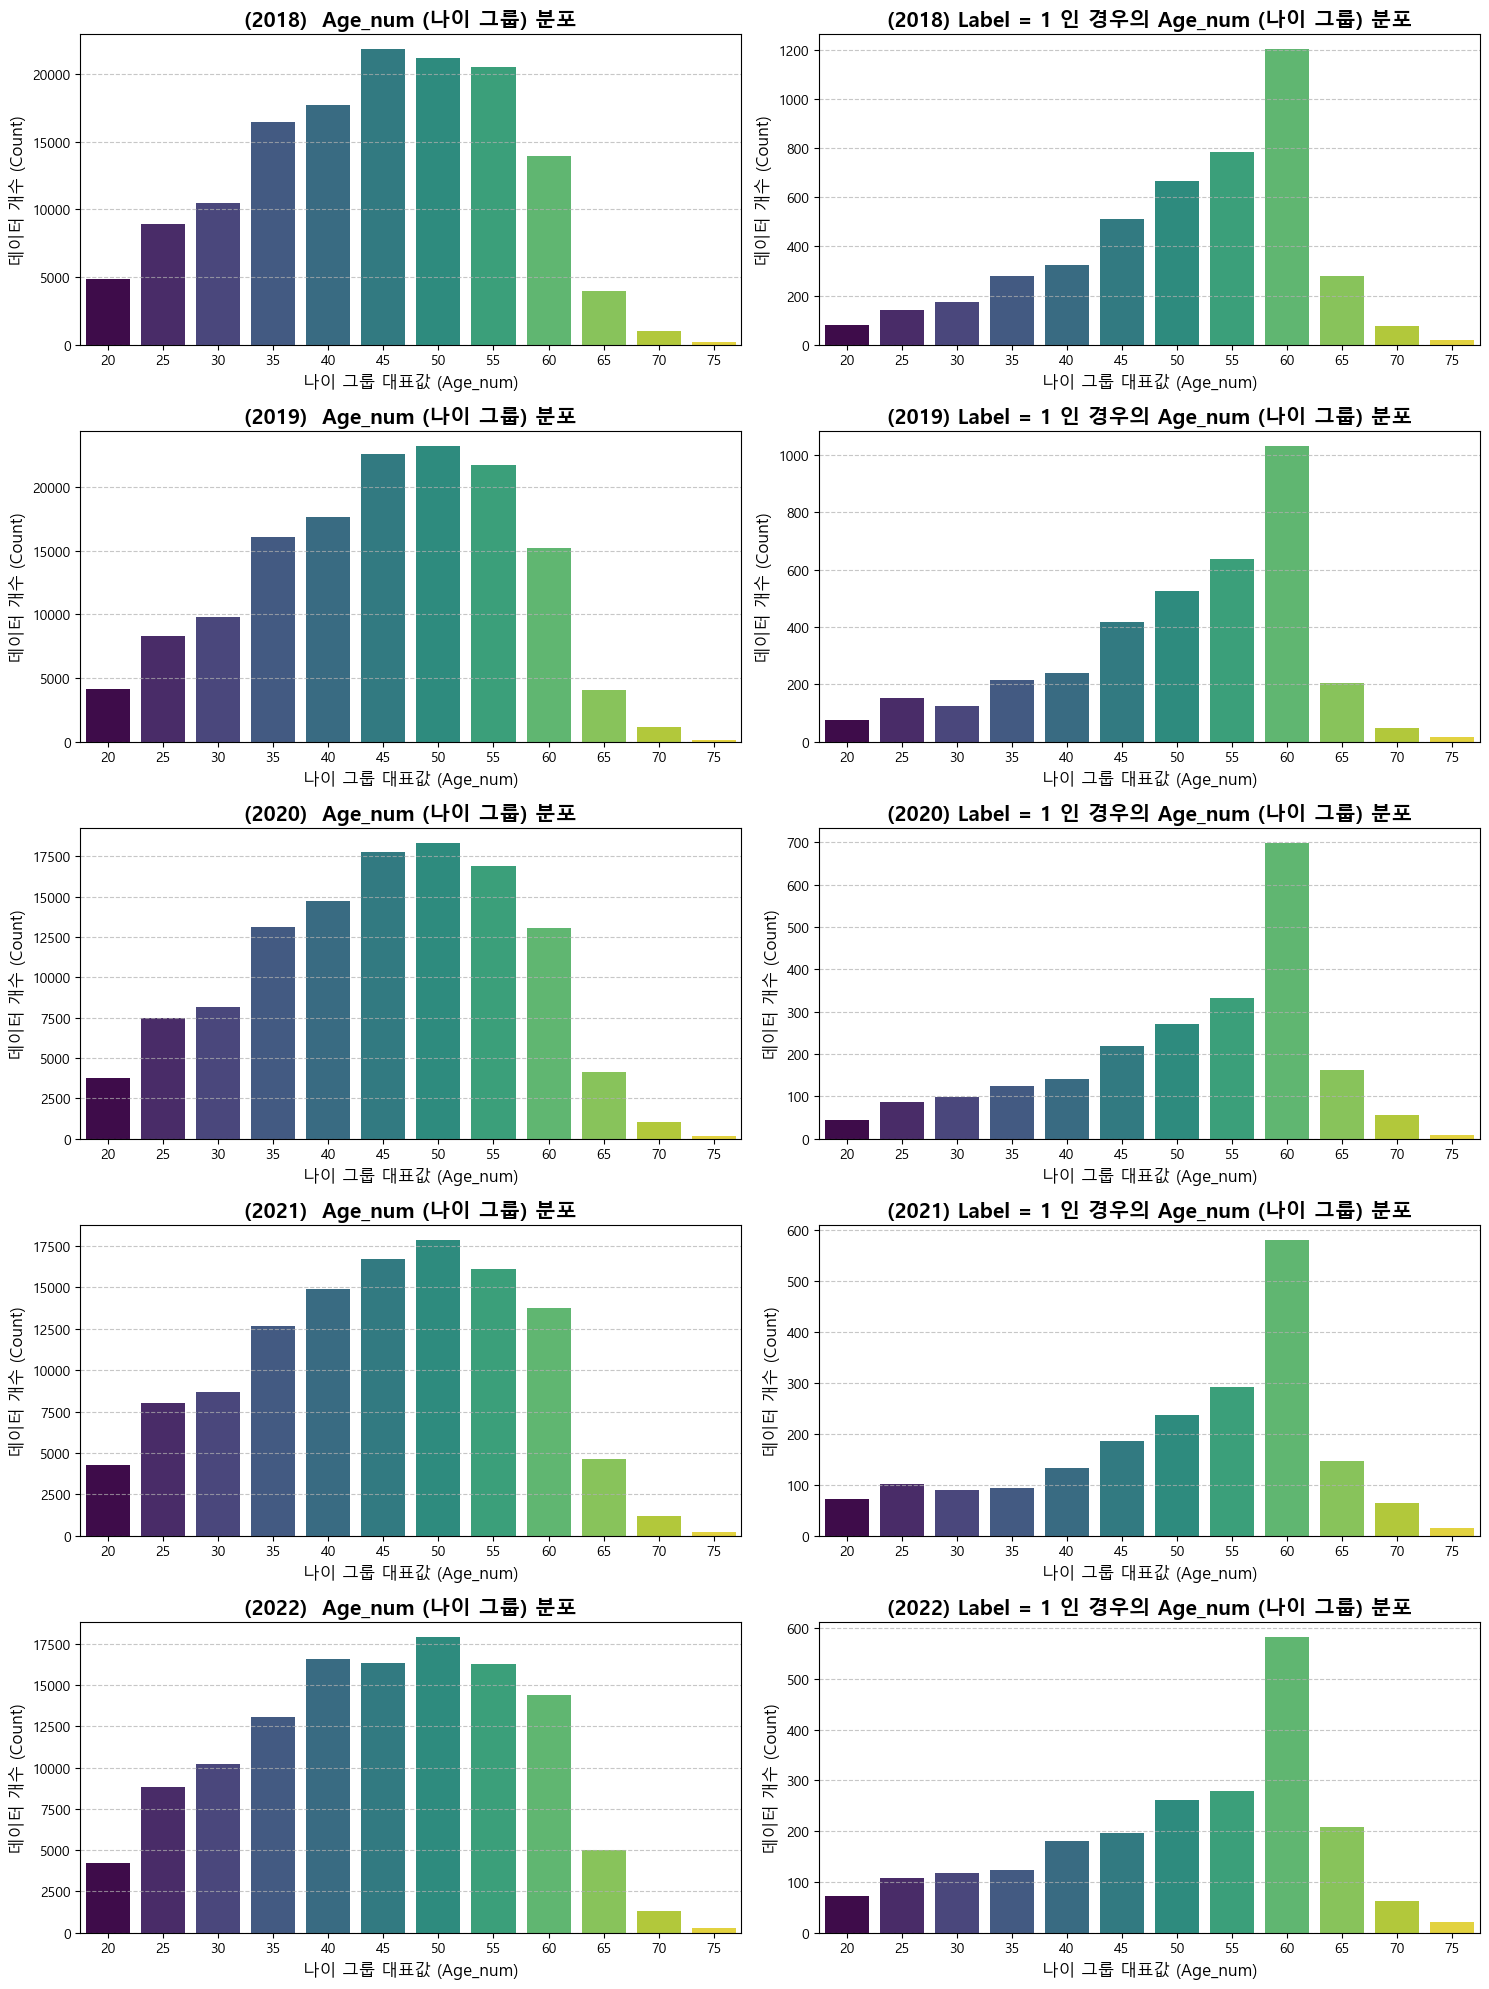

모든 Label == 1 그래프에서 Age_num이 60일 때 가장 높은 count를 가짐


In [18]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

train_A_label1 = train_A[train_A['Label'] == 1].copy()
age_order = sorted(train_A['Age_num'].dropna().unique())
age_order_label1 = sorted(train_A_label1['Age_num'].dropna().unique())
for i in range(len(year)):
    # 기본
    sns.countplot(data=train_A.loc[train_A['Year'] == year[i]], x='Age_num', ax=axes[i, 0],
                  palette='viridis', order=age_order, hue='Age_num', legend=False)
    
    # Label == 1
    sns.countplot(data=train_A_label1[train_A_label1['Year'] == year[i]], x='Age_num', ax=axes[i, 1],
                  palette='viridis', order=age_order, hue='Age_num', legend=False)
    
    axes[i, 0].set_title(f'({year[i]})  Age_num (나이 그룹) 분포', fontsize=15, fontweight='bold')
    axes[i, 0].set_xlabel('나이 그룹 대표값 (Age_num)', fontsize=12)
    axes[i, 0].set_ylabel('데이터 개수 (Count)', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=0)
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)

    axes[i, 1].set_title(f'({year[i]}) Label = 1 인 경우의 Age_num (나이 그룹) 분포', fontsize=15, fontweight='bold')
    axes[i, 1].set_xlabel('나이 그룹 대표값 (Age_num)', fontsize=12)
    axes[i, 1].set_ylabel('데이터 개수 (Count)', fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=0)
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print('모든 Label == 1 그래프에서 Age_num이 60일 때 가장 높은 count를 가짐')

In [19]:
# 중복된 PrimaryKey를 가진 행들의 개수
P_mask = (train_A['PrimaryKey'].value_counts() > 1 )
keys = P_mask[P_mask].index

df = train_A[train_A['PrimaryKey'].isin(keys)]

print(f'중복된 PrimaryKey를 갖는 행들의 개수: {len(df)}')

중복된 PrimaryKey를 갖는 행들의 개수: 66847


In [20]:
# 피처에 과거 응시 횟수 생성
train_A = train_A.sort_values(by=['PrimaryKey', 'TestDate']) # Key, Date 순 정렬
train_A['past_attempts'] = train_A.groupby('PrimaryKey').cumcount() # 과거 횟수

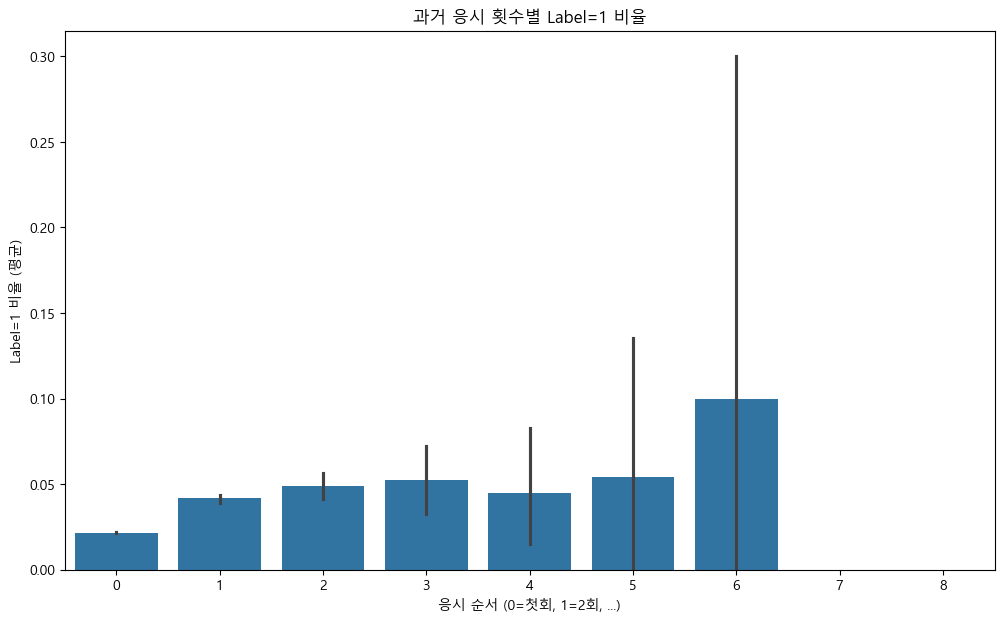

재 응시할 시 Label=1의 비율이 2배 이상으로 늘어남


In [21]:
plt.figure(figsize=(12, 7))
sns.barplot(data=train_A, x='past_attempts', y='Label')

plt.title('과거 응시 횟수별 Label=1 비율')
plt.xlabel('응시 순서 (0=첫회, 1=2회, ...)')
plt.ylabel('Label=1 비율 (평균)')
plt.show()

print('재 응시할 시 Label=1의 비율이 2배 이상으로 늘어남')

In [24]:
train_A_features = preprocess_A(train_A)

Step 1: Age, TestDate 파생...
Step 2: A1 feature 생성...


100%|██████████| 647241/647241 [00:07<00:00, 81601.19it/s]


Step 3: A2 feature 생성...


100%|██████████| 647241/647241 [00:07<00:00, 83100.98it/s]


Step 4: A3 feature 생성...


100%|██████████| 647241/647241 [00:08<00:00, 76068.02it/s]


Step 5: A4 feature 생성...


100%|██████████| 647241/647241 [00:10<00:00, 59018.94it/s]


Step 6: A5 feature 생성...


100%|██████████| 647241/647241 [00:00<00:00, 763588.40it/s]


Step 7: 시퀀스 컬럼 drop & concat...
A 검사 데이터 전처리 완료


In [25]:
train_A_features = add_features_A(train_A_features)

In [47]:
train_A_features.columns

Index(['Test_id', 'Label', 'PrimaryKey', 'Age', 'TestDate', 'A6-1', 'A7-1',
       'A8-1', 'A8-2', 'A9-1', 'A9-2', 'A9-3', 'A9-4', 'A9-5', 'Age_num',
       'Year', 'Month', 'YearMonth', 'past_attempts', 'A1_resp_rate',
       'A1_rt_mean', 'A1_rt_std', 'A1_rt_left', 'A1_rt_right',
       'A1_rt_side_diff', 'A1_rt_slow', 'A1_rt_fast', 'A1_rt_speed_diff',
       'A2_resp_rate', 'A2_rt_mean', 'A2_rt_std', 'A2_rt_cond1_diff',
       'A2_rt_cond2_diff', 'A3_valid_ratio', 'A3_invalid_ratio',
       'A3_correct_ratio', 'A3_resp2_rate', 'A3_rt_mean', 'A3_rt_std',
       'A3_rt_size_diff', 'A3_rt_side_diff', 'A4_acc_rate', 'A4_resp2_rate',
       'A4_rt_mean', 'A4_rt_std', 'A4_stroop_diff', 'A4_rt_color_diff',
       'A5_acc_rate', 'A5_resp2_rate', 'A5_acc_nonchange', 'A5_acc_change',
       'YearMonthIndex', 'A1_speed_acc_tradeoff', 'A2_speed_acc_tradeoff',
       'A4_speed_acc_tradeoff', 'A1_rt_cv', 'A2_rt_cv', 'A3_rt_cv', 'A4_rt_cv',
       'A1_rt_side_gap_abs', 'A1_rt_speed_gap_abs', 'A2_r

In [88]:
drop_cols = ['Test_id', 'PrimaryKey', 'Age', 'TestDate', 'Year', 'Month', 'YearMonth', 'A3_valid_ratio', 'A3_invalid_ratio']
cols = [i for i in train_A_features.columns if i not in drop_cols]

In [89]:
corr_mat = train_A_features[cols].corr()

In [90]:
corr_mat.iloc[:10, :10]

,Label,A6-1,A7-1,A8-1,A8-2,A9-1,A9-2,A9-3,A9-4,A9-5
Label,1.000000,-0.052774,-0.046485,0.016195,0.027949,0.021305,0.008319,0.019116,0.005525,0.016082
A6-1,-0.052774,1.000000,0.606909,-0.152650,-0.276880,-0.239554,-0.148558,-0.259976,-0.154483,-0.176474
A7-1,-0.046485,0.606909,1.000000,-0.135013,-0.253022,-0.218387,-0.144127,-0.217002,-0.137449,-0.159399
A8-1,0.016195,-0.152650,-0.135013,1.000000,-0.103847,-0.123741,-0.213482,0.131432,-0.211331,-0.123000
A8-2,0.027949,-0.276880,-0.253022,-0.103847,1.000000,0.526658,0.519040,0.246436,0.484512,0.462838
A9-1,0.021305,-0.239554,-0.218387,-0.123741,0.526658,1.000000,0.628795,0.424335,0.661356,0.671705
A9-2,0.008319,-0.148558,-0.144127,-0.213482,0.519040,0.628795,1.000000,0.309450,0.690141,0.646211
A9-3,0.019116,-0.259976,-0.217002,0.131432,0.246436,0.424335,0.309450,1.000000,0.321366,0.357070
A9-4,0.005525,-0.154483,-0.137449,-0.211331,0.484512,0.661356,0.690141,0.321366,1.000000,0.584814
A9-5,0.016082,-0.176474,-0.159399,-0.123000,0.462838,0.671705,0.646211,0.357070,0.584814,1.000000


In [92]:
corr_mat.shape

(58, 58)

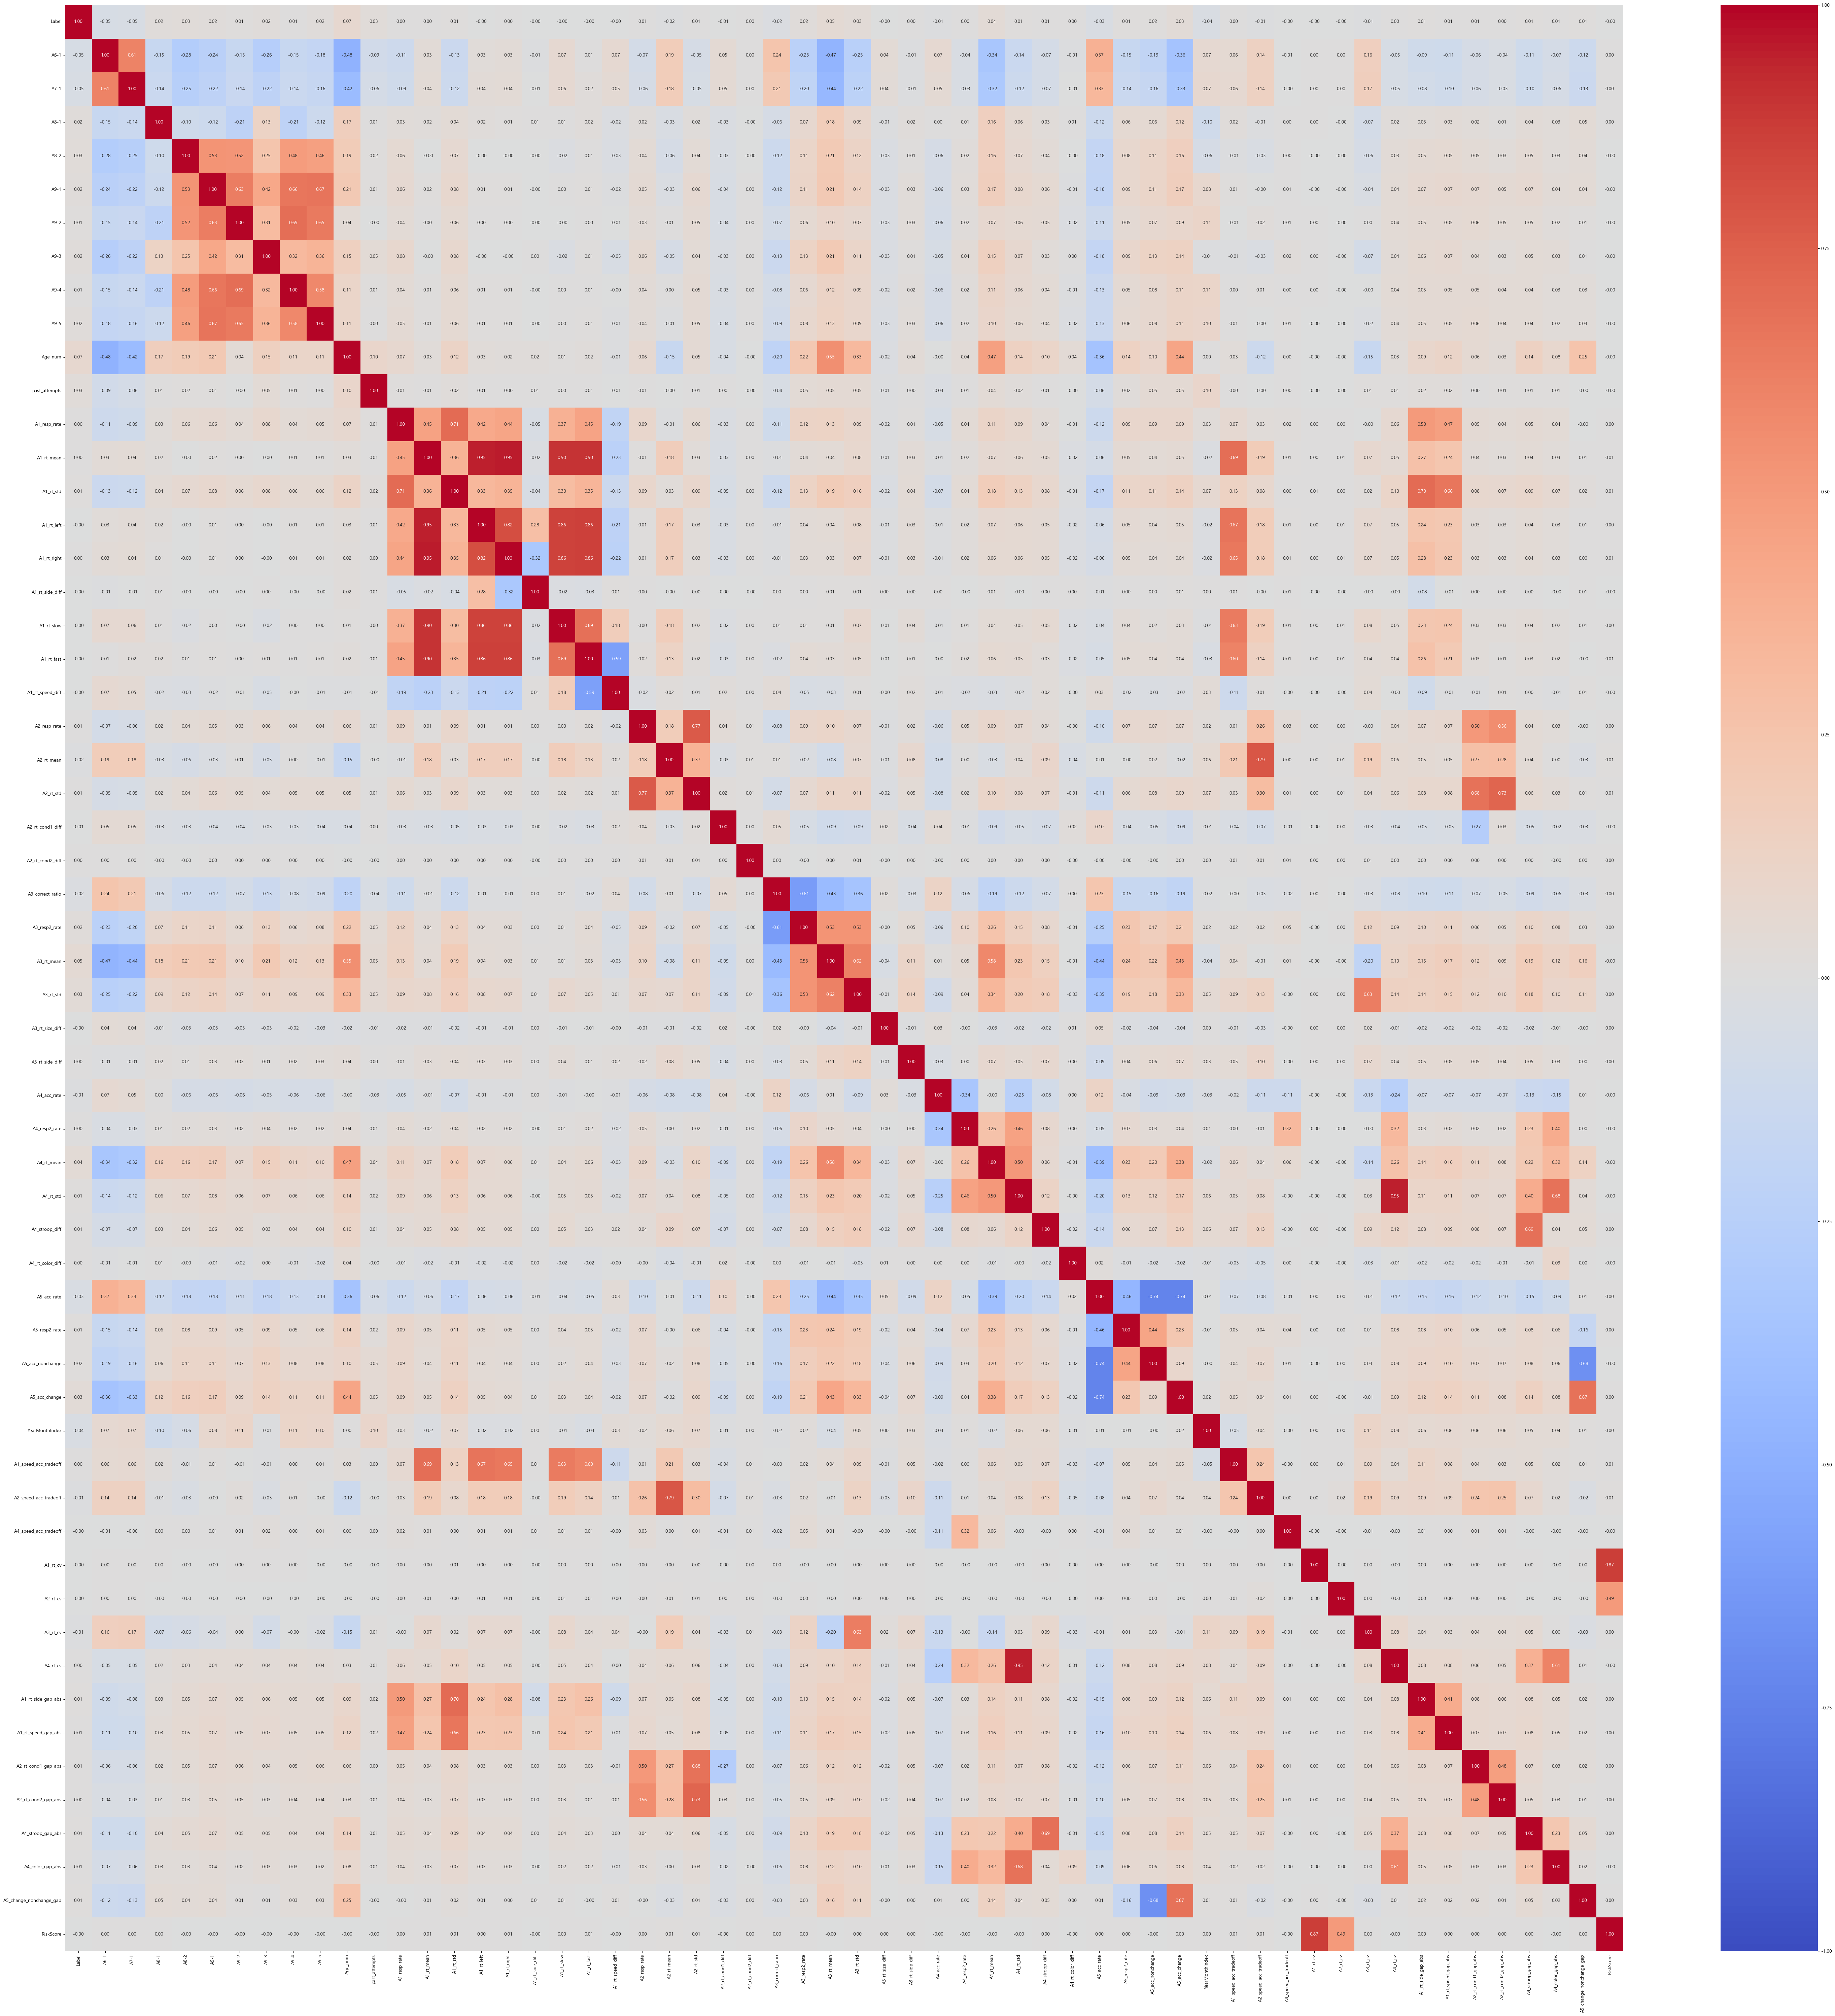

In [93]:
plt.figure(figsize=(60, 60))
sns.heatmap(corr_mat, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
plt.tight_layout()